In [77]:
# =============================
# FUNCTIONS for overlapping pulses 
# =============================

############## Bath parameters ##############
global Boltzmann, hbar, Temp
Boltzmann = 1.0
hbar = 1.0

Temp = 1  # changeable

# functions from test_baths.py
from test_baths import (
    spectral_density_func_paper,
    Power_spectrum_func_paper,
)

from concurrent.futures import ThreadPoolExecutor, as_completed
from matplotlib.colors import TwoSlopeNorm, LinearSegmentedColormap
import matplotlib.pyplot as plt
from qutip.solver import Result
from qutip import *
import numpy as np
import itertools
import os

# Import the outsourced plot settings
from plot_settings import *

In [85]:
# =============================
# SYSTEM PARAMETERS     (**changeable**)
# =============================
global N_atoms, Coupled, ODE_Solver, omega_laser, E0, E_freqs, E_amps, omega_A, mu_A, mu_B, theta, J, rabi_0, delta_rabi, RWA_laser, gamma_phi
N_atoms = 2  # Set the number of atoms only works for 2
assert N_atoms == 2, "This code only works for 2 atoms"
Coupled = True  # Set coupling condition

fac_two_pi = 1 * 2 * np.pi  # Factor to convert from Hertz to angular frequency [fs^-1] -> [rads/ fs] -> also have to adjust the plotting of the 2D spectrum
RWA_laser = True  #  CAN ONLY HANDLE TRUE For MY solver (paper)   only valid for omega_laser ~ omega_A
ODE_Solver = "Paper_eqs"  # "Paper_eqs" (solve the EOMs from the paper) or "Paper_BR" do d/dt rho = -i/hbar * [H0 - Dip * E, rho] + R(rho)

pulse_duration = 15  # [fs]
E0 = 0.01  # (**changeable*) Amplitude of the laser field -> determines Rabi freq!      excitation should be <=1%!!!


### Phase Cycling for Averaging
phases = [k * np.pi / 2 for k in range(4)]
### Define Atomic States
atom_g, atom_e = basis(2, 0), basis(2, 1)  # Ground, Excited states
psi_ini = ket2dm(tensor(atom_g, atom_g))  # initial state ground state

# values from the paper: [cm-1] linear wavenumber, usually used in spectroscopy
omega_laser = 16000 # in the middle of the two transitions
### If the excited states are coupled -> modified the energy levels
if Coupled:
    J = 300.0
    omega_A = 16200.0
    omega_B = 15800.0
    mu_A = 1.0
    mu_B = -0.23
else:
    J = 0.0
    omega_A = 16360.0 # todo
    omega_B = 15640.0
    mu_A = 1.0
    mu_B = 1 * mu_A

### Coupling to the bath
gamma_phi = 3 * 1e1  # (**changeable**): dim. less Dephasing rate
cutoff = 1e1 * omega_A # (**changeable**) (high?) cutoff frequency
args_paper = {
    "g": gamma_phi,
    "cutoff": cutoff,
    "Boltzmann": Boltzmann,
    "hbar": hbar,
    "Temp": Temp,
}


### define the parameters
theta = np.arctan(2 * J / (omega_A - omega_B)) / 2
omega_laser *= fac_two_pi * 2.998 * 10**-5 #  omega = 2 pi c[10*2 cm/10*15 fs] nu_tilde: [fs⁻¹]
omega_A *= fac_two_pi * 2.998 * 10**-5
omega_B *= fac_two_pi * 2.998 * 10**-5
J *= fac_two_pi * 2.998 * 10**-5
print("omega_L, omega_A, omega_B, J", omega_laser, omega_A, omega_B, J)

E_freqs = [omega_laser] * 3  # Laser frequencies
E_amps = [E0, E0, 1e-2 * E0]  # third one is small to simulate a probe field

### NEW: ANALYTIC DIAGONALIZATION OF THE HAMILTONIAN; LIKE IN THE PAPER
eigenenergy_1 = 1 / 2 * (omega_A + omega_B) - 1 / 2 * np.sqrt(
    (omega_A - omega_B) ** 2 + 4 * J**2
)
eigenenergy_2 = 1 / 2 * (omega_A + omega_B) + 1 / 2 * np.sqrt(
    (omega_A - omega_B) ** 2 + 4 * J**2
)
eigenenergy_3 = omega_A + omega_B
global eigenenergies
eigenenergies = [0, eigenenergy_1, eigenenergy_2, eigenenergy_3]
print(eigenenergies)
C_A_1 = -np.sin(theta)
C_A_2 = np.cos(theta)
C_B_1 = C_A_2
C_B_2 = -C_A_1

eigenvecs = [
    tensor(atom_g, atom_g),
    C_A_1 * tensor(atom_e, atom_g) + C_B_1 * tensor(atom_g, atom_e),
    C_A_2 * tensor(atom_e, atom_g) + C_B_2 * tensor(atom_g, atom_e),
    tensor(atom_e, atom_e),
]

mu_10 = mu_A * C_A_1 + mu_B * C_A_2
mu_20 = mu_A * C_B_1 + mu_B * C_B_2
mu_31 = mu_B * C_A_1 + mu_A * C_B_1
mu_32 = mu_B * C_B_1 + mu_A * C_B_2

sm_list = [
    mu_10 * (eigenvecs[0] * eigenvecs[1].dag()).unit(),
    mu_20 * (eigenvecs[0] * eigenvecs[2].dag()).unit(),
    mu_31 * (eigenvecs[1] * eigenvecs[3].dag()).unit(),
    mu_32 * (eigenvecs[2] * eigenvecs[3].dag()).unit(),
]
SM_op = sum(sm_list)
Dip_op = SM_op + SM_op.dag()


cplng_ops_to_env = [
    ket2dm(tensor(atom_e, atom_g)),
    ket2dm(tensor(atom_g, atom_e)),
    ket2dm(tensor(atom_e, atom_e)),
]

Deph_op = sum(cplng_ops_to_env)
env = BosonicEnvironment.from_spectral_density(
    lambda w: spectral_density_func_paper(w, args_paper), wMax=10 * cutoff, T=Temp
)
a_ops_list = [
    [
        cplng_ops_to_env[0],
        env.power_spectrum,
    ],  # atom A with ohmic_spectrum
    [
        cplng_ops_to_env[1],
        env.power_spectrum,
    ],  # atom B with ohmic_spectrum
    [
        cplng_ops_to_env[2],
        lambda w: env.power_spectrum(2 * w),
    ],  # double excited state with 2 * ohmic_spectrum
]

c_ops_list = [np.sqrt(gamma_phi) * Deph_op]
e_ops_list1 = [
    ket2dm(tensor(atom_g, atom_g)),
    ket2dm(tensor(atom_e, atom_g)),
    ket2dm(tensor(atom_g, atom_e)),
    ket2dm(tensor(atom_e, atom_e)),
]
e_ops_list2 = [
    ket2dm(state) for state in eigenvecs
]
e_ops_labels1 = [f"{i}" for i in range(len(eigenvecs))]
e_ops_labels2 = ["0", "A", "B", "AB"]

e_ops_list = e_ops_list2
e_ops_labels = e_ops_labels2 


# Rabi oscillation / coupling to the laser
g_value = (mu_A * mu_B) * E0  # TODO check.  this might lead to a uncorrect rabi period
rabi_0 = g_value / hbar
delta_rabi = omega_laser - omega_A  # detuning from center of manifold
rabi_gen = np.sqrt(
    rabi_0**2 + delta_rabi**2
)

t_max_L = 6 * 2 * np.pi / omega_laser  # Just the six periods of the laser rotation
t_prd = 2 * np.pi / rabi_gen
fine_spacing = 0.01 * min(t_prd, pulse_duration)
t_max_r = max(200, 0.01 * t_prd)  # (**changeable**) # 5 periods of the rabi oscillation
t_max = t_max_r
Delta_ts = [pulse_duration/2] * 3
print("Period for one Rabi oscillation: T/fs  = ", t_prd)
print("fine spacing = ", fine_spacing)

omega_L, omega_A, omega_B, J 3.0139183281479043 3.051592307249753 2.9762443490460555 0.056510968652773205
[0, 2.946000596446667, 3.0818360598491417, 6.027836656295809]
Period for one Rabi oscillation: T/fs  =  166.4679179612559
fine spacing =  0.15


In [86]:
# ##########################
# independent of system
# ##########################
def plot_positive_color_map(
    datas,
    T_wait=np.inf,
    space="real",
    type="real",
    output_dir=None,
    ODE_Solver=None,
    positive=False,
    safe=False,
    use_custom_colormap=False,
    section = None, # tuple of (x_min, x_max, y_min, y_max)
):
    """
    Create a color plot of 2D functional data for positive x and y values only.

    Parameters:
        datas (tuple): Tuple containing (x, y, data) where x and y are 1D arrays and data is a 2D array.
        T_wait (float): waiting time to include in plot title and file name.
        space (str): Either 'real' or 'freq' specifying the space of the data.
        type (str): Type of data ('real', 'imag', 'abs', or 'phase'). Used only if space="freq".
        positive (bool): Whether to use ONLY positive values of x and y.
        safe (bool): If True, saves the plot to a file.
        output_dir (str, optional): Directory to save the plot.

    Returns:
        None
    """
    # Ensure datas is a tuple with (x, y, data)
    if not isinstance(datas, tuple) or len(datas) != 3:
        raise ValueError("datas must be a tuple of (x, y, data)")

    x, y, data = datas  # corresponds to ts, taus, data

    # Validate that x, y, and data are numpy arrays
    x = np.real(x)
    y = np.real(y)
    data = np.array(data) / np.abs(data).max()

    # Check if data dimensions match x and y
    if data.shape[1] != len(x):
        raise ValueError(
            f"Length of x ({len(x)}) must match the number of columns in data ({data.shape[1]})."
        )
    if data.shape[0] != len(y):
        raise ValueError(
            f"Length of y ({len(y)}) must match the number of rows in data ({data.shape[0]})."
        )

    if space != "real" and space != "freq":
        raise ValueError("Invalid space. Must be 'real' or 'freq'.")
    elif space == "real":
        colormap = "viridis"
        title = r"$\text{Real space}$"
        x_title = r"$t_{\text{det}}$ [fs]"
        y_title = r"$\tau_{\text{coh}}$ [fs]"
    elif space == "freq": 
        colormap = "plasma"
        title = r"$\text{Freq space}$"
        x_title = r"$\omega_{t_{\text{det}}}$ [$10^4$ cm$^{-1}$]"
        y_title = r"$\omega_{\tau_{\text{coh}}}$ [$10^4$ cm$^{-1}$]"
        

    if type != "real" and type != "imag" and type != "abs" and type != "phase":
        raise ValueError("Invalid Type. Must be 'real', 'imag', 'abs', or 'phase'.")    
    elif type == "real":
        title += r"$\text{, Real 2D Spectrum}$"
        data = np.real(data).astype(np.float64)
    elif type == "imag":
        title += r"$\text{, Imag 2D Spectrum}$"
        data = np.imag(data).astype(np.float64)
    elif type == "abs":
        title += r"$\text{, Abs 2D Spectrum}$"
        data = np.abs(data).astype(np.float64)
        use_custom_colormap = False
    elif type == "phase":
        title += r"$\text{, Phase 2D Spectrum}$"
        data = np.angle(data).astype(np.float64)

    if T_wait != np.inf:
        title += rf"$\ \text{{at }} T = {T_wait:.2f}$"

    # Filter for positive x and y values if requested
    if positive:
        # Ensure the data array has even dimensions
        rows, cols = data.shape
        if rows % 2 != 0:
            data = data[:-1, :]  # Remove the last row if the number of rows is odd
        if cols % 2 != 0:
            data = data[:, :-1]  # Remove the last column if the number of columns is odd

        # Recalculate the midpoints after adjusting dimensions
        mid_x = len(x) // 2
        mid_y = len(y) // 2

        # Extract quadrants
        q1 = data[mid_y:, mid_x:]  # First quadrant
        q2 = data[mid_y:, :mid_x]  # Second quadrant
        q3 = data[:mid_y, :mid_x]  # Third quadrant
        q4 = data[:mid_y, mid_x:]  # Fourth quadrant

        # Average the quadrants
        averaged_data = (q1 + np.flip(q3, axis=(0, 1))) / 2 #  np.flip(q2, axis=1) +  + np.flip(q4, axis=0)

        # Update x, y, and data to only include the first quadrant
        x = x[mid_x:]
        y = y[mid_y:]
        data = averaged_data    # plot only a small portion of the data
    if section is not None:
        x_min, x_max, y_min, y_max = section
        x_indices = np.where((x >= x_min) & (x <= x_max))[0]
        y_indices = np.where((y >= y_min) & (y <= y_max))[0]
        # Ensure indices are within bounds
        x_indices = x_indices[x_indices < data.shape[1]]
        y_indices = y_indices[y_indices < data.shape[0]]
        data = data[np.ix_(y_indices, x_indices)]
        x = x[x_indices]
        y = y[y_indices]

    norm = None
    if use_custom_colormap:
        vmin            = np.min(data)
        vmax            = np.max(data)
        vcenter         = 0

        # Create a colormap that forces zero values to white
        cmap = plt.get_cmap("bwr")
        colors = cmap(np.linspace(0, 1, 256))
        mid = 128  # Middle index
        colors[mid] = [1, 1, 1, 1]  # Pure white in RGBA
        colormap = LinearSegmentedColormap.from_list("white_centered", colors)

        # Ensure vmin, vcenter, and vmax are in ascending order
        if vmin < vcenter < vmax:
            norm = TwoSlopeNorm(vmin=vmin, vcenter=vcenter, vmax=vmax)
        else:
            print(f"Warning: Cannot use TwoSlopeNorm with vmin={vmin}, vcenter={vcenter}, vmax={vmax}. Using default normalization.")
    # Set the colorbar label
    cbarlabel = r"$\propto E_{\text{out}} / E_{0}$"

    # Plot the color map
    plt.figure(figsize=(10, 8))


    plt.pcolormesh(
        x, y, data,
        shading="auto",
        cmap=colormap,
        norm=norm,
    )
    plt.colorbar(label=cbarlabel)
    plt.title(title)
    plt.xlabel(x_title)
    plt.ylabel(y_title)

    # Save the plot if safe is True and output_dir is provided
    if safe and output_dir is not None:
        assert os.path.isdir(
            output_dir
        ), f"Output directory {output_dir} does not exist."

        filename_parts = [
            f"M={N_atoms}",
            f"mua={mu_eg:.0f}",
            f"E0={E0:.2e}",
            f"wa={omega_A:.2f}",
            f"wL={omega_laser / omega_A:.1f}wa",
            f"rabigen={rabi_gen:.2f}= sqrt({rabi_0:.2f}^2+{delta_rabi:.2f}^2)",
            f"pos={positive}",
            f"space={space}",
        ]

        if ODE_Solver == "Paper_eqs":
            filename_parts.append(f"Paper_eqs")

        if space == "freq":
            filename_parts.append(f"type_{type}")

        file_name_combined = "_".join(filename_parts) + ".svg"
        save_path_combined = os.path.join(output_dir, file_name_combined)
        plt.savefig(save_path_combined)
    else:
        print("Plot not saved. Ensure 'safe' is True and 'output_dir' is specified.")
    plt.show()
#CKECKED

def get_expect_vals_with_RWA(states, times, e_ops=e_ops_list, omega=omega_laser):
    """
    Calculate the expectation values in the result with RWA phase factors.

    Parameters:
        states= data.states (where data = qutip.Result): Results of the pulse evolution.
        times (list): Time points at which the expectation values are calculated.
        e_ops (list): the operators for which the expectation values are calculated
        omega (float): omega_laser (float): Frequency of the laser.
    Returns:
        list of lists: Expectation values for each operator of len(states).
    """
    if RWA_laser:
        # Apply RWA phase factors to each state
        states = [
            apply_RWA_phase_factors(state, time, omega)
            for state, time in zip(states, times)
        ]

    updated_expects = [np.real(expect(states, e_op)) for e_op in e_ops]
    return updated_expects
#CKECKED

def get_pulse_args(curr, prev=None, preprev=None):
    """
    Generate pulse arguments for multiple pulses based on the current time, phase, and pulse index.

    Parameters:
        curr = (t0_cur, phi_curr) (tuple of floats): starting time and phase kick of the current pulse
        prev = (t0_prev, phi_prev)  (tuple of floats, optional): Start time and phase kick of the previous pulse. Defaults to None.
        preprev = (t0_preprev, phi_preprev) (tuple of floats, optional): Start time and phase kick of the first pulse. Defaults to None.

    Returns:
        dict: Dictionary containing pulse parameters for the current and potentially previous.
    """
    # i (int): Index of the current pulse (0, 1, or 2).
    args = []
    i = 0

    if prev != None:
        i = 1
        t0_prev, phi_prev = prev
        if preprev != None:
            i = 2
            t0_preprev, phi_preprev = preprev
            args.append({
                "pulse_phase": phi_preprev,
                "pulse_start_time": t0_preprev,
                "pulse_freq": E_freqs[i-2],
                "pulse_half_width": Delta_ts[i-2],
                "pulse_amplitude": E_amps[i-2], 
            })
        args.append({
            "pulse_phase": phi_prev,
            "pulse_start_time": t0_prev,
            "pulse_freq": E_freqs[i-1],
            "pulse_half_width": Delta_ts[i-1],
            "pulse_amplitude": E_amps[i-1], 
        })
    
    t0_curr, phi_curr = curr
    args.append({
        "pulse_phase": phi_curr,
        "pulse_start_time": t0_curr,
        "pulse_freq": E_freqs[i],
        "pulse_half_width": Delta_ts[i],
        "pulse_amplitude": E_amps[i],
    })
    return {"pulses": args}
def pulse_envelope(t, args):
    """
    Calculate the combined envelope of multiple pulses.

    Parameters:
        t (float): Time at which the envelope is evaluated.
        args (dict): Dictionary containing a list of pulse parameters under the key "pulses".

    Returns:
        float: Combined envelope value at time t.
    """
    envelope = 0.0
    for params in args["pulses"]:
        t0          = params["pulse_start_time"]  # Start time of the pulse
        Delta_width = params["pulse_half_width"]  # Half-width of the pulse

        # Add the envelope contribution if within the pulse range
        if t0 <= t <= t0 + 2 * Delta_width:
            envelope += np.cos(np.pi * (t - (t0 + Delta_width)) / (2 * Delta_width)) ** 2
    # Example: check for zero or negative pulse width
    if Delta_width == 0:
        raise ValueError("Pulse half-width Delta_width is zero!")

    # Example: check for NaN/inf in envelope
    if not np.isfinite(envelope):
        raise ValueError(f"Envelope is not finite at t={t}, args={args}")
    return envelope
def E_pulse(t, args):
    """
    Define a time-dependent electric field pulse with combined envelopes.

    Parameters:
        t (float): Time at which the electric field is evaluated.
        args (dict): Dictionary containing pulse parameters:
            - "pulses": List of dictionaries for each pulse, each containing:
                - "pulse_start_time": Start time of the pulse.
                - "pulse_half_width": Half-width of the pulse.
                - "pulse_phase": Phase of the pulse.
                - "pulse_amplitude": Amplitude of the pulse.

    Returns:
        complex: Combined electric field value at time t.
    """
    E_total = 0.0
    for pulse in args["pulses"]:
        phi         = pulse["pulse_phase"]
        E0          = pulse["pulse_amplitude"]
        # Calculate the envelope for this pulse
        Env = pulse_envelope(t, {"pulses": [pulse]})
        # Calculate the electric field for this pulse
        E = E0 * Env * np.exp(-1j * phi)  # Phase factor
        E_total +=  E  # Add the contribution of this pulse
    return E_total / 2
def Epsilon_pulse(t, args):
    """
    Define a time-dependent electric field pulse with combined envelopes and rotation,
    using the existing pulse_envelope() function.

    Parameters:
        t (float): Time at which the electric field is evaluated.
        args (dict): Dictionary containing pulse parameters:
            - "pulses": List of dicts for each pulse, each containing:
                - "pulse_start_time"
                - "pulse_half_width"
                - "pulse_freq"
                - "pulse_phase"
                - "pulse_amplitude"

    Returns:
        complex: Combined electric field value at time t.
    """
    omega = args["pulses"][0]["pulse_freq"]
    E_total = E_pulse(t, args) * np.exp(-1j * omega *t)
    return E_total
def plot_pulse_envelope(times, args, ax=None):
    """
    Plot the combined pulse envelope over time for up to three pulses.

    Parameters:
        times (array): Array of time values.
        args (dict): Dictionary containing a list of pulse parameters under the key "pulses".
        ax (matplotlib.axes.Axes, optional): Axes object to plot on. Defaults to None.

    Returns:
        ax (matplotlib.axes.Axes): Axes object with the plot.
    """
    # Calculate the combined envelope over time
    envelope = [pulse_envelope(t, args) for t in times]

    # Create figure and axis if not provided
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 6))

    # Plot combined envelope
    ax.plot(
        times,
        envelope,
        label=r"$\text{Combined Envelope}$",
        linestyle="solid",
        alpha=0.8,
        color="C0",
    )

    # Styles for up to three pulses
    linestyles = ["dashed", "dashdot", "dotted"]
    colors = ["C1", "C2", "C3"]

    # Plot individual envelopes and annotations
    for idx, params in enumerate(args["pulses"][:3]):  # Up to 3 pulses
        t0 = params["pulse_start_time"]
        Delta_width = params["pulse_half_width"]

        # Compute individual pulse envelope
        individual_envelope = [
            np.cos(np.pi * (t - (t0 + Delta_width)) / (2 * Delta_width)) ** 2
            if t0 <= t <= t0 + 2 * Delta_width else 0.0
            for t in times
        ]

        ax.plot(
            times,
            individual_envelope,
            label=rf"$\text{{Pulse {idx + 1}}}$",
            linestyle=linestyles[idx % len(linestyles)],
            alpha=0.6,
            color=colors[idx % len(colors)],
        )

        # Annotate pulse key points
        ax.axvline(
            t0,
            linestyle="dotted",
            label=rf"$t_{{0, {idx + 1}}}$",
            alpha=0.4,
            color=colors[idx % len(colors)],
        )
        ax.axvline(
            t0 + Delta_width,
            linestyle="dashdot",
            label=rf"$t_{{0, {idx + 1}}} + \Delta_{{{idx + 1}}}$",
            alpha=0.6,
            color=colors[idx % len(colors)],
        )
        ax.axvline(
            t0 + 2 * Delta_width,
            linestyle="dotted",
            label=rf"$t_{{0, {idx + 1}}} + 2\Delta_{{{idx + 1}}}$",
            alpha=0.4,
            color=colors[idx % len(colors)],
        )

    # Final plot labeling
    ax.set_xlabel(r"Time $t$")
    ax.set_ylabel(r"Envelope Amplitude")
    ax.set_title(r"Pulse Envelopes for Up to Three Pulses")
    ax.legend(loc="upper right", fontsize="small")
    return ax
def El_field_3_pulses(times, args, f=Epsilon_pulse):
    """
    Calculate the combined electric field and time ranges for three pulses.

    Parameters:
        times (array): Time range for the three pulses.
        args (dict): all arguments of the three pulses
    Returns:
        tuple: Combined time range (times_plot) and electric field (E_total).
    """
    ### Calculate the electric fields for each time range

    E0 = args["pulses"][0]["pulse_amplitude"]
    E = np.array([f(t, args) for t in times])
    if f != pulse_envelope:
        E /= 0.5 * E0
    return E
test_times = np.linspace(-10, 40, 2000)
test_args = get_pulse_args(curr=(test_times[0]+4*Delta_ts[0], 0), prev=(test_times[0]+2*Delta_ts[0], phases[1]), preprev=(test_times[0], phases[2]))
# plot_pulse_envelope(test_times, test_args)
y0 = El_field_3_pulses(test_times, test_args, f=pulse_envelope)
#plt.plot(test_times, y0, label="envelope")
#y1 = El_field_3_pulses(test_times, test_args, f=E_pulse)
#plt.plot(test_times, np.real(y1), label="Re(E)")
#plt.plot(test_times, np.imag(y1), label="Im(E)")
y2 = El_field_3_pulses(test_times, test_args, f=Epsilon_pulse)
#plt.plot(test_times, np.real(y2), label=r"Re(Epsilon)")
#plt.plot(test_times, np.imag(y2), label=r"Im(Epsilon)")
#plt.plot(test_times, np.abs(y2), label=r"Abs(Epsilon)")
#plt.legend()
def get_tau_cohs_and_t_dets_for_T_wait(times, T_wait):
    """
    Calculate the time arrays for tau_coh and t_det based on the waiting time T_wait and spacing.

    Parameters:
        T_wait (float): Waiting time.
        spacing (float): Time spacing.
        end (float): the final time

    Returns:
        tuple: Arrays for coherence and detections times tau_coh and t_det.
        both have the same len(_)
    """
    ### Calculate the first and last entries for tau_coh times
    if times.size != 0:
        spacing = times[1]-times[0]
        t_max = times[-1]
    else:
        raise(ValueError)
        
    if T_wait > t_max:
        print("there are no tau_coh / t_det vals because T_wait >= t_max")
    if T_wait == t_max:
        return np.array([0]), np.array([0])
    time_0 = 0 # pulses can overlap!!
    time_max = t_max - T_wait
    times_ = np.arange(time_0, time_max , spacing) # time_max is not included!

    return times_, times_

def H_int(t, args):
    """
    Define the interaction Hamiltonian for the system with multiple pulses.

    Parameters:
        t (float): Time at which the interaction Hamiltonian is evaluated.
        args (dict): Dictionary containing pulse parameters:
            - "pulses": List of dictionaries for each pulse.

    Returns:
        Qobj: Interaction Hamiltonian at time t.
    """
    # Calculate the electric field based on whether RWA is applied
    if RWA_laser:
        E_field = E_pulse(t, args)  # Use the combined electric field under RWA
        H_int   = -(SM_op.dag() * E_field + SM_op * np.conj(E_field))  # Interaction Hamiltonian in RWA
    else:
        E_field = Epsilon_pulse(t, args)  # Use the combined electric field with rotation
        H_int   = -Dip_op * (E_field + np.conj(E_field))  # Full interaction Hamiltonian

    return H_int


In [87]:
# ##########################
# dependent of system
# ##########################
def apply_RWA_phase_factors(rho, t, omega=omega_laser):
    """
    Apply time-dependent phase factors to the density matrix entries.

    Parameters:
        rho (Qobj): Density matrix (Qobj) to modify.
        omega (float): Frequency of the phase factor.
        t (float): Current time.

    Returns:
        Qobj: Modified density matrix with phase factors applied.
    """
    # Extract the density matrix as a NumPy array
    rho_array = rho.full()
    # print(rho.isherm)

    # Apply the phase factors to the specified elements
    phase_1 = np.exp(-1j * omega * t)  # e^(-i * omega * t)
    phase_2 = np.exp(-1j * 2 * omega * t)  # e^(-i * 2 * omega * t)

    # Modify the elements
    bar_alpha = 3
    for alpha in range(1, 3):
        rho_array[alpha, 0] *= phase_1  # rho_alpha_0 = sigma_alpha_0 * e^(-i * omega * t)
        rho_array[0, alpha] *= np.conj(phase_1)

        rho_array[bar_alpha, alpha] *= phase_1  # rho_bar_alpha_alpha = sigma_bar_alpha_alpha * e^(-i * omega * t)
        rho_array[alpha, bar_alpha] *= np.conj(phase_1)

    rho_array[bar_alpha, 0] *= phase_2  # rho_bar_alpha_0 = sigma_bar_alpha_0 * e^(-i * 2 * omega * t)
    rho_array[0, bar_alpha] *= np.conj(phase_2)

    rho_result = Qobj(rho_array, dims=rho.dims)
    # print(rho_array[0, 1], rho_array[1,0])

    #assert rho_result.isherm, "The resulting density matrix is not Hermitian."

    return rho_result


# =============================
# "Paper_eqs" OWN ODE SOLVER
# =============================

def Hamilton_dimer_sys(omega_A, omega_B, J, hbar=hbar):
    """Hamiltonain of a dimer system (two coupled(J) tls').

    Args:
        hbar (float): reduced Planck's constant
        omega_A (float): site A atomic energy 
        omega_B (float): site B atomic energy 
        J (float): coupling const
    Returns:
        Qobj: Hamiltonian operator of the two-level system
    """
    H = hbar * (
        omega_A * ket2dm(tensor(atom_e, atom_g))
        + omega_B * ket2dm(tensor(atom_g, atom_e))
        + J
        * (
            tensor(atom_e, atom_g) * tensor(atom_g, atom_e).dag()
            + tensor(atom_g, atom_e) * tensor(atom_e, atom_g).dag()
        )
        + (omega_A + omega_B) * ket2dm(tensor(atom_e, atom_e))
    )
    return H


### DEFINE DEPHASING AND DECAY RATES
def omega_ij(i, j):
    """
    Calculate the energy difference between two states.

    Parameters:
        i (int): Index of the first state.
        j (int): Index of the second state.

    Returns:
        float: Energy difference between the two states.
    """
    return eigenenergies[i] - eigenenergies[j]  # energy difference

def gamma_small_ij(i, j):
    """
    Calculate the population relaxation rates.

    Parameters:
        i (int): Index of the first state.
        j (int): Index of the second state.

    Returns:
        float: Population relaxation rate.
    """

    w_ij = omega_ij(i, j)
    return np.sin(2 * theta) ** 2 * Power_spectrum_func_paper(w_ij, args_paper)

def Gamma_big_ij(i, j):
    """
    Calculate the pure dephasing rates.

    Parameters:
        i (int): Index of the first state.
        j (int): Index of the second state.

    Returns:
        float: Pure dephasing rate.
    """
    # Pure dephasing rates helper
    P_0 = Power_spectrum_func_paper(0, args_paper)
    Gamma_t_ab = 2 * np.cos(2 * theta)** 2 * P_0 # tilde
    Gamma_t_a0 = (1 - 0.5 * np.sin(2 * theta)** 2) * P_0
    Gamma_11 = gamma_small_ij(2, 1)
    Gamma_22 = gamma_small_ij(1, 2)
    Gamma_abar_0 = 2 * P_0
    Gamma_abar_a = Gamma_abar_0 # holds for dimer
    if i == 1:
        if j == 0:
            return Gamma_t_a0 + 0.5 * gamma_small_ij(2, i)
        elif j == 1:
            return Gamma_11
        elif j == 2:
            return Gamma_t_ab + 0.5 * (gamma_small_ij(i, j) + gamma_small_ij(j, i))
    if i == 2:
        if j == 0:
            return Gamma_t_a0 + 0.5 * gamma_small_ij(1, i)
        elif j == 1:
            return Gamma_t_ab + 0.5 * (gamma_small_ij(i, j) + gamma_small_ij(j, i))
        elif j == 2:
            return Gamma_22
    elif i == 3:
        if j == 0:
            return Gamma_abar_0
        elif j == 1:
            return Gamma_abar_a + 0.5 * (gamma_small_ij(2, j))
        elif j == 2:
            return Gamma_abar_a + 0.5 * (gamma_small_ij(1, j))
    else:
        raise ValueError("Invalid indices for i and j.")

def matrix_ODE_paper(t, args):
    """including RWA.
    Constructs the matrix L(t) for the equation drho_dt = L(t) * rho,
    where rho is the flattened density matrix.
    """
    Et = E_pulse(t, args)
    Et_conj = np.conj(Et)

    L = np.zeros((16, 16), dtype=complex)

    # Indices for the flattened density matrix:
    # 0: rho00, 1: rho01, 2: rho02, 3: rho03
    # 4: rho10, 5: rho11, 6: rho12, 7: rho13
    # 8: rho20, 9: rho21, 10: rho22, 11: rho23
    # 12: rho30, 13: rho31, 14: rho32, 15: rho33


    # --- d/dt rho_10 ---
    term = -1j * (omega_ij(1, 0) - omega_laser) - Gamma_big_ij(1, 0)
    L[4, 4] = term                          # ρ₁₀ ← ρ₁₀
    L[4, 0] = 1j * Et * Dip_op[1, 0]        # ρ₁₀ ← ρ₀₀
    L[4, 5] = -1j * Et * Dip_op[1, 0]       # ρ₁₀ ← ρ₁₁
    L[4, 6] = -1j * Et * Dip_op[2, 0]       # ρ₁₀ ← ρ₁₂
    L[4, 12] = 1j * Et_conj * Dip_op[3, 1]  # ρ₁₀ ← ρ₃₀
    
    # --- d/dt rho_01 ---
    L[1, 1] = np.conj(term)                 # ρ₀₁ ← ρ₀₁
    L[1, 0] = -1j * Et * Dip_op[1, 0]       # ρ₀₁ ← ρ₀₀
    L[1, 5] = 1j * Et * Dip_op[1, 0]        # ρ₀₁ ← ρ₁₁
    L[1, 9] = 1j * Et * Dip_op[2, 0]        # ρ₀₁ ← ρ₂₁
    L[1, 3] = -1j * Et_conj * Dip_op[3, 1]  # ρ₀₁ ← ρ₀₃
    
    # --- d/dt rho_20 ---
    term = -1j * (omega_ij(2, 0) - omega_laser) - Gamma_big_ij(2, 0)
    L[8, 8] = term                          # ρ₂₀ ← ρ₂₀
    L[8, 0] = 1j * Et * Dip_op[2, 0]        # ρ₂₀ ← ρ₀₀
    L[8, 10] = -1j * Et * Dip_op[2, 0]      # ρ₂₀ ← ρ₂₂
    L[8, 9] = -1j * Et * Dip_op[1, 0]       # ρ₂₀ ← ρ₂₁
    L[8, 12] = 1j * Et_conj * Dip_op[3, 2]  # ρ₂₀ ← ρ₃₀

    # --- d/dt rho_02 ---
    L[2, 2] = np.conj(term)                 # ρ₀₂ ← ρ₀₂
    L[2, 0] = -1j * Et * Dip_op[2, 0]       # ρ₀₂ ← ρ₀₀
    L[2, 10] = 1j * Et * Dip_op[2, 0]       # ρ₀₂ ← ρ₂₂
    L[2, 6] = 1j * Et * Dip_op[1, 0]        # ρ₀₂ ← ρ₁₂
    L[2, 3] = -1j * Et_conj * Dip_op[3, 2]  # ρ₀₂ ← ρ₀₃

    # --- d/dt rho_30 ---
    term = -1j * (omega_ij(3, 0) - 2 * omega_laser) - Gamma_big_ij(3, 0)
    L[12, 12] = term                        # ρ₃₀ ← ρ₃₀
    L[12, 4] = 1j * Et * Dip_op[3, 1]       # ρ₃₀ ← ρ₁₀
    L[12, 8] = 1j * Et * Dip_op[3, 2]       # ρ₃₀ ← ρ₂₀
    L[12, 13] = -1j * Et * Dip_op[1, 0]     # ρ₃₀ ← ρ₃₁
    L[12, 14] = -1j * Et * Dip_op[2, 0]     # ρ₃₀ ← ρ₃₂

    # --- d/dt rho_03 ---
    L[3, 3] = np.conj(term)                 # ρ₀₃ ← ρ₀₃
    L[3, 1] = -1j * Et * Dip_op[3, 1]       # ρ₀₃ ← ρ₀₁
    L[3, 2] = -1j * Et * Dip_op[3, 2]       # ρ₀₃ ← ρ₀₂
    L[3, 7] = 1j * Et_conj * Dip_op[1, 0]   # ρ₀₃ ← ρ₁₃
    L[3, 11] = 1j * Et_conj * Dip_op[2, 0]  # ρ₀₃ ← ρ₂₃

    # --- d/dt rho_12 ---
    term = -1j * omega_ij(1, 2) - Gamma_big_ij(1, 2)
    L[6, 6] = term                          # ρ₁₂ ← ρ₁₂
    L[6, 2] = 1j * Et * Dip_op[1, 0]        # ρ₁₂ ← ρ₀₂
    L[6, 7] = -1j * Et * Dip_op[3, 2]       # ρ₁₂ ← ρ₁₃
    L[6, 14] = 1j * Et_conj * Dip_op[3, 1]  # ρ₁₂ ← ρ₃₂
    L[6, 4] = -1j * Et_conj * Dip_op[2, 0]  # ρ₁₂ ← ρ₁₀

    # --- d/dt rho_21 ---
    L[9, 9] = np.conj(term)                 # ρ₂₁ ← ρ₂₁
    L[9, 8] = -1j * Et * Dip_op[1, 0]       # ρ₂₁ ← ρ₂₀
    L[9, 13] = 1j * Et * Dip_op[3, 2]       # ρ₂₁ ← ρ₃₁
    L[9, 9] = -1j * Et_conj * Dip_op[3, 1]  # ρ₂₁ ← ρ₂₁
    L[9, 1] = 1j * Et_conj * Dip_op[1, 0]   # ρ₂₁ ← ρ₀₁

    # --- d/dt rho_31 ---
    term = -1j * (omega_ij(3, 1) - omega_laser) - Gamma_big_ij(3, 1)
    L[13, 13] = term                        # ρ₃₁ ← ρ₃₁
    L[13, 5] = 1j * Et * Dip_op[3, 1]       # ρ₃₁ ← ρ₁₁
    L[13, 9] = 1j * Et * Dip_op[3, 2]       # ρ₃₁ ← ρ₂₁
    L[13, 12] = -1j * Et_conj * Dip_op[1, 0]# ρ₃₁ ← ρ₃₀

    # --- d/dt rho_13 ---
    L[7, 7] = np.conj(term)                 # ρ₁₃ ← ρ₁₃
    L[7, 5] = -1j * Et * Dip_op[3, 1]       # ρ₁₃ ← ρ₁₁
    L[7, 6] = -1j * Et * Dip_op[3, 2]       # ρ₁₃ ← ρ₁₂
    L[7, 3] = 1j * Et_conj * Dip_op[1, 0]   # ρ₁₃ ← ρ₀₃

    # --- d/dt rho_32 ---
    term = -1j * (omega_ij(3, 2) - omega_laser) - Gamma_big_ij(3, 2)
    L[14, 14] = term                        # ρ₃₂ ← ρ₃₂
    L[14, 10] = 1j * Et * Dip_op[3, 2]      # ρ₃₂ ← ρ₂₂
    L[14, 6] = 1j * Et * Dip_op[3, 1]       # ρ₃₂ ← ρ₁₂
    L[14, 12] = -1j * Et_conj * Dip_op[2, 0]# ρ₃₂ ← ρ₃₀

    # --- d/dt rho_23 ---
    L[11, 11] = np.conj(term)               # ρ₂₃ ← ρ₂₃
    L[11, 10] = -1j * Et * Dip_op[3, 2]     # ρ₂₃ ← ρ₂₂
    L[11, 9] = -1j * Et * Dip_op[3, 1]      # ρ₂₃ ← ρ₂₁
    L[11, 3] = 1j * Et_conj * Dip_op[2, 0]  # ρ₂₃ ← ρ₀₃

    ### Diagonals
    # --- d/dt rho_00 ---
    L[0, 1] = -1j * Et * Dip_op[1, 0]
    L[0, 2] = -1j * Et * Dip_op[2, 0]
    L[0, 4] = 1j * Et_conj * Dip_op[1, 0]
    L[0, 8] = 1j * Et_conj * Dip_op[2, 0]

    # --- d/dt rho_11 ---
    L[5, 5] = -1 * Gamma_big_ij(1, 1)
    L[5, 10] = gamma_small_ij(1, 2)
    L[5, 1] = 1j * Et * Dip_op[1, 0]
    L[5, 7] = -1j * Et * Dip_op[3, 1]
    L[5, 13] = 1j * Et_conj * Dip_op[3, 1]
    L[5, 4] = -1j * Et_conj * Dip_op[1, 0]

    # --- d/dt rho_22 ---
    L[10, 10] = -1 * Gamma_big_ij(2, 2)
    L[10, 5] = gamma_small_ij(2, 1)
    L[10, 2] = 1j * Et * Dip_op[2, 0]
    L[10, 11] = -1j * Et * Dip_op[3, 2]
    L[10, 14] = 1j * Et_conj * Dip_op[3, 2]
    L[10, 8] = -1j * Et_conj * Dip_op[2, 0]

    # --- d/dt rho_00 --- and  --- d/dt rho_33 (sum d/dt rho_ii = 0) (trace condition) ---
    L[15, :] = -1 * np.sum(L[[0, 5, 10], :], axis=0) # TODO not mentioned in paper, i will assume it to conserve the trace
    # print("the trace d/dt (rho_00 + rho_11 + rho_22 + rho_33) = ", np.sum(L[[0, 5, 10, 15], :]), "should be 0")

    return Qobj(L, dims=[[[2, 2], [2, 2]], [[2, 2], [2, 2]]])

# only use the Redfield tensor as a matrix:
def R_paper():
    """including RWA
    Constructs the Redfield Tensor R for the equation drho_dt = -i(Hrho - rho H) + R * rho,
    where rho is the flattened density matrix.
    """
    R = np.zeros((16, 16), dtype=complex)

    # Indices for the flattened density matrix:
    # 0: rho00, 1: rho01, 2: rho02, 3: rho03
    # 4: rho10, 5: rho11, 6: rho12, 7: rho13
    # 8: rho20, 9: rho21, 10: rho22, 11: rho23
    # 12: rho30, 13: rho31, 14: rho32, 15: rho33

    # --- d/dt rho_10 ---
    term = -1j * (omega_ij(1, 0) - omega_laser) - Gamma_big_ij(1, 0)
    R[4, 4] = term

    # --- d/dt rho_01 ---
    R[1, 1] = np.conj(term)

    # --- d/dt rho_20 --- = ANSATZ = (d/dt s_20 - i omega_laser s_20) e^(-i omega_laser t)
    term = -1j * (omega_ij(2, 0) - omega_laser) - Gamma_big_ij(2, 0)
    R[8, 8] = term

    # --- d/dt rho_02 ---
    R[2, 2] = np.conj(term)

    # --- d/dt rho_30 ---
    term = -1j * (omega_ij(3, 0) - 2 * omega_laser) - Gamma_big_ij(3, 0)
    R[12, 12] = term

    # --- d/dt rho_03 ---
    R[3, 3] = np.conj(term)

    # --- d/dt rho_12 ---
    term = -1j * omega_ij(1, 2) - Gamma_big_ij(1, 2)
    R[6, 6] = term

   # --- d/dt rho_21 ---
    R[9, 9] = np.conj(term)
    
    # --- d/dt rho_31 ---
    term = -1j * (omega_ij(3, 1) - omega_laser) - Gamma_big_ij(3, 1)
    R[13, 13] = term

    # --- d/dt rho_13 ---
    R[7, 7] = np.conj(term)

    # --- d/dt rho_32 ---
    term = -1j * (omega_ij(3, 2) - omega_laser) - Gamma_big_ij(3, 2)
    R[14, 14] = term

    # --- d/dt rho_23 ---
    R[11, 11] = np.conj(term)

    ### Diagonals
    # --- d/dt rho_11 ---
    R[5, 5] = -Gamma_big_ij(1, 1)
    R[5, 10] = gamma_small_ij(1, 2)

    # --- d/dt rho_22 ---
    R[10, 10] = -Gamma_big_ij(2, 2)
    R[10, 5] = gamma_small_ij(2, 1)

    # NOW THERE IS NO POPULATION CHANGE in 3 || 1 goes to 2 and vice versa 
    # --- d/dt rho_00 --- and  --- d/dt rho_33 (sum d/dt rho_ii = 0) (trace condition) ---
    # R[15, :] = -1 * np.sum(R[[0, 5, 10], :], axis=0)
    #R[0, :] = -1 * np.sum(R[[5, 10, 15], :], axis=0) # i think the ground state should get repopulated

    return Qobj(R, dims=[[[2, 2], [2, 2]], [[2, 2], [2, 2]]])

def Liouville(args):
    return QobjEvo(matrix_ODE_paper, args)

def compute_pulse_evolution(psi_ini, times, curr, prev=None, preprev=None, omega_at=omega_A):
    """
    Compute the evolution of the i-th pulse starting from the current state psi_ini.
    times[0] =^= psi_ini

    Parameters:
        psi_ini (Qobj): Initial quantum state.
        times (array): Time array for the evolution.
        curr = (t0_cur, phi_curr) (tuple of floats): starting time and phase kick of the current pulse
        prev = (t0_prev, phi_prev)  (tuple of floats, optional): Start time and phase kick of the previous pulse. Defaults to None.
        preprev = (t0_preprev, phi_preprev) (tuple of floats, optional): Start time and phase kick of the first pulse. Defaults to None.
        omega_at (float): Atomic frequency for the free Hamiltonian.

    Returns:
        Qutip.Result: Result of the evolution.
    """
    # Set solver options
    progress_bar = "enhanced" if preprev != None and times[0] >= times[len(times) // 2] else ""
    options = {
        "store_states": True,
        "progress_bar": progress_bar,
    }
    
    args = get_pulse_args(curr, prev, preprev)

    # Choose solver and compute the evolution
    if ODE_Solver != "Paper_eqs" and ODE_Solver != "ME" and ODE_Solver != "Paper_BR":
            raise ValueError(f"Unknown ODE solver: {ODE_Solver}")
    elif ODE_Solver == "Paper_eqs":
        L = Liouville(args)
        result = mesolve(
            L,
            psi_ini,
            times,
            options=options,
        )
    else:
        # =============================
        # Split the evolution into two parts:
        # 1. With H_int for the pulse duration
        # 2. With H0 for the rest
        # =============================
        # Find the index where times = times[0] + 2*Delta_ts[0]
        if prev is None:
            i = 0
        elif preprev is None:
            i = 1
        else:
            i = 2
        t_pulse_end = curr[0] + 2 * Delta_ts[i] # = the start of the current pulse! + pulse duration
        idx_split = np.abs(times - t_pulse_end).argmin()

        global eigenenergies
        Es = eigenenergies
        # --- First part: with H_int ---
        if RWA_laser:
            Es = [
                Es[0],
                Es[1] - omega_laser,
                Es[2] - omega_laser,
                Es[3] - 2 * omega_laser,
            ]

        H_free = Qobj(np.diag(Es), dims=[[2, 2], [2, 2]]) 
        H_int_evo = H_free + QobjEvo(H_int, args)

        c_ops = []
        if ODE_Solver == "Paper_BR":
            c_ops= [R_paper()]
        elif ODE_Solver == "ME":
            c_ops= c_ops_list

        result = mesolve(
            H_int_evo,
            psi_ini,
            times,
            c_ops=c_ops,
            options=options,
        )

        """
        times1 = times[:idx_split]
        result1 = mesolve(
            H_int_evo,
            psi_ini,
            times1,
            c_ops=[R_paper()],
            options=options,
        )

        # --- Second part: with H0 only ---
        # Use the last state as initial state for the second part
        psi_after_pulse = result1.states[-1]
        times2 = times[idx_split:]
        if len(times2) > 0:
            result2 = mesolve(
                H_free,
                psi_after_pulse,
                times2,
                c_ops=c_ops,
                options=options,
            )
            # Combine results
            all_states = list(result1.states) + list(result2.states)
            all_times = list(result1.times) + list(result2.times)
            options_full = options.copy()
            if "store_final_state" not in options_full:
                options_full["store_final_state"] = False
            if "store_states" not in options_full:
                options_full["store_states"] = True
            result = Result(e_ops=[], options=options_full)
            result.states = all_states
            result.times = all_times
            # Copy other attributes if needed
        else:
            result = result1"""

    return result

In [88]:
# ##########################
# independent of system
# ##########################
def check_the_solver(psi_ini, times, e_ops_list):
    """
    Checks the solver within the compute_pulse_evolution function
    with the provided psi_ini, times, and e_ops_list.

    Parameters:
        psi_ini (qutip.Qobj): Initial quantum state.
        times (numpy.ndarray): Time array for the evolution.
        e_ops_list (list of qutip.Qobj): List of expectation value operators.

    Returns:
        None: Prints the results of the checks.  Raises exceptions on errors.
    """
    print(f"Checking '{ODE_Solver}' solver ")

    # 1. Input Validation
    # ----------------------
    if not isinstance(psi_ini, qutip.Qobj):
        raise TypeError("psi_ini must be a qutip.Qobj")
    if not isinstance(times, np.ndarray):
        raise TypeError("times must be a numpy.ndarray")
    if not isinstance(e_ops_list, list) or not all(isinstance(op, qutip.Qobj) for op in e_ops_list):
        raise TypeError("e_ops_list must be a list of qutip.Qobj")

    if len(times) < 2:
        raise ValueError("times must have at least two elements")

    # 2. Call the function to be checked
    # ----------------------------------
    phi_0 = np.pi/2
    phi_1 = np.pi/4
    t_start_0 = 0
    t_start_1 = 10
    t_start_2 = 15
    pulse_0=(t_start_0, phi_0)
    pulse_1=(t_start_1, phi_1)
    phi_2 = 0
    pulse_f=(t_start_2, phi_2)
    result = compute_pulse_evolution(psi_ini, times, curr=pulse_f, prev=pulse_1, preprev=pulse_0)

    # 3. Check the result (basic checks)
    # ----------------------------------
    if not isinstance(result, qutip.Result):
        raise TypeError("Result must be a qutip.Result object")

    # Add more specific checks as needed for your implementation
    if result.times != list(times):
        raise ValueError("Result times do not match input times")

    if len(result.states) != len(times):
        raise ValueError("Number of output states does not match number of time points")
    
    # 4. Check if density matrix is Hermitian, positive, and trace-preserving
    # ------------------------------------------------------
    strg = ""
    global time_cut
    for index, state in enumerate(result.states):
        if RWA_laser:
            state = apply_RWA_phase_factors(state, times[index], omega=omega_laser)
        time = times[index]
        if not state.isherm:
            strg += f"Density matrix is not Hermitian after t = {time}.\n"
            print(state)
        eigvals = state.eigenenergies()
        #print(eigvals)
        time_cut = np.inf # time after which the evolution becomes unphysical, to be decided in check_the_solver
        if not np.all(eigvals >= -1e-3):  # allow for small numerical negative eigenvalues
            strg += f"Density matrix is not positive semidefinite after t = {time}: The lowest eigenvalue is {eigvals.min()}.\n"
            time_cut = time
        if not np.isclose(state.tr(), 1.0):
            strg += f"Density matrix is not trace-preserving after t = {time}: The trace is {state.tr()}.\n "
            time_cut = time
        if strg:
            strg += "Adjust your parameters!"
            print(strg) # raise ValueError(strg)
            break
    else: print("Checks passed. solver appears to be called correctly, and density matrix remains Hermitian and positive.")

    return result

def compute_two_dimensional_polarization(T_wait, phi_0, phi_1, times, omega_at=omega_A, plot_example=False):
    """
    Compute the two-dimensional polarization for a given waiting time (T_wait) and 
    the phases of the first and second pulses (phi_0, phi_1).

    Parameters:
        T_wait (float): Waiting time between the second and third pulses.
        phi_0 (float): Phase of the first pulse.
        phi_1 (float): Phase of the second pulse.

    Returns:
        tuple: A tuple containing:
            - tau_coh_vals (numpy.ndarray): Array of coherence times (tau_coh).
            - t_det_vals (numpy.ndarray): Array of detection times (t_det).
            - data (numpy.ndarray): 2D array of polarization values.
    """

    # get the symmetric times, tau_coh, t_det
    tau_coh_vals, t_det_vals = get_tau_cohs_and_t_dets_for_T_wait(times, T_wait=T_wait)

    # initialize the time domain Spectroscopy data tr(Dip_op * rho_final(tau_coh, t_det))
    data = np.zeros((len(tau_coh_vals), len(t_det_vals)), dtype=np.complex64) # might get uncontrollable big!TODO
    # MAYBE USE FILES: data = np.memmap('spectroscopy_data.dat', dtype='complex128', mode='w+', shape=(len(tau_coh_vals), len(t_det_vals)))
    
    idx_start_0 = 0     
    t_start_0 = times[idx_start_0] # ALWAYS the starting point of the first pulse
    idx_end_0 = np.abs(times - (Delta_ts[0])).argmin()
    # only make the necessary steps (don't calculate too many states that we don't need)
    # latest time at which the next pulse starts:
    idx_start_1_max = np.abs(times - (tau_coh_vals[-1] - Delta_ts[1])).argmin()
    times_0 = times[: idx_start_1_max + 1] # definetly not empty except for when T_wait >= t_max
    if times_0.size == 0:
        times_0 = times[idx_start_0:idx_end_0+1]
    # calculate the evolution of the first pulse in the desired range for tau_coh

    pulse_0=(t_start_0, phi_0)

    data_0 = compute_pulse_evolution(psi_ini, times_0, curr=pulse_0, omega_at=omega_at)
    # for every tau_coh value -> calculate the next two pulses          # print(f"(T_wait): {T_wait}, (t_max): {t_max}")
    for tau_idx, tau_coh in enumerate(tau_coh_vals):                    # print(tau_coh, tau_idx)
        # Calculate the start and end indices for the second pulse
        idx_start_1 = np.abs(times - (tau_coh - Delta_ts[1])).argmin()
        t_start_1   = times[idx_start_1]  # Start time of the second pulse        # idx_end_1   = np.abs(times - (t_start_1 + 2 * Delta_ts[1])).argmin() # end of the second pulse
        idx_end_1 = np.abs(times - (tau_coh + Delta_ts[1])).argmin() # index at which the second pulse ends
        # Take the state (after / also during) the first pulse and evolve it with the second (and potentially overlaped first) pulse
        rho_1 = data_0.states[idx_start_1]

        # select range  ->  to reduce computation time
        idx_start_2 = np.abs(times - (tau_coh + T_wait - Delta_ts[2])).argmin()
        idx_end_2 = np.abs(times - (tau_coh + T_wait + Delta_ts[2])).argmin()
        t_start_2 = times[idx_start_2] # the time at which the third pulse starts
        idx_end_2 = np.abs(times - (tau_coh + T_wait + Delta_ts[2])).argmin() # end of the third pulse
        # idx_start_2_0 = np.abs(times - (T_wait - Delta_ts[2])).argmin() # the first time at which the third pulse starts

        times_1 = times[idx_start_1:idx_start_2+1] # like this: also take the overlap into account; 
        
        if times_1.size == 0:
            times_1 = times[idx_start_1:idx_end_1+1]
        # Handle overlapping pulses: If the second pulse starts before the first pulse ends, combine their contributions
        pulse_1=(t_start_1, phi_1)
        data_1 = compute_pulse_evolution(rho_1, times_1, curr=pulse_1, prev=pulse_0, omega_at=omega_at)

        idx_start_2_in_times_1 = np.abs(times_1 - (t_start_2)).argmin()
        
        rho_2 = data_1.states[idx_start_2_in_times_1] # == state where the third pulse starts

        times_2 = times[idx_start_2:] # the rest of the evolution (third pulse, potentially overlapped with previouses) # can be empty, if tau_coh + T_wait >= t_max 
        if times_2.size == 0:
            times_2 = times[idx_start_2:idx_end_2+1]
        # If the second pulse starts before the first pulse ends, combine their contributions
        phi_2 = 0 # FIXED PHASE!
        pulse_f=(t_start_2, phi_2)

        data_f = compute_pulse_evolution(rho_2, times_2, curr=pulse_f, prev=pulse_1, preprev=pulse_0, omega_at=omega_at)

        for t_idx, t_det in enumerate(t_det_vals):
              
            # store the data for the case
            if t_idx + tau_idx < len(tau_coh_vals):
                actual_det_time = t_start_2 + Delta_ts[2] + t_det
                t_idx_in_times_2 = np.abs(times_2  - (actual_det_time)).argmin() # detection time index in times_2

                # only if we are still in the physical regime
                if actual_det_time < time_cut:
                    rho_f = data_f.states[t_idx_in_times_2]
                    
                    if RWA_laser:
                        rho_f = apply_RWA_phase_factors(rho_f, times_2[t_idx_in_times_2], omega=omega_laser)
                    value = expect(Dip_op, rho_f)
                    data[tau_idx, t_idx] = (
                        np.real(value) # Rolarization P(t)= ("Real")(<Dip_op>)
                    )                                                                   # print(f"(t_det): {t_det}, (tau_coh): {tau_coh}, (data): {value}, Time index in times_2: {t_idx_in_times_2}")

                    # make one plot for this case
                    if (t_idx == 0 and tau_idx == len(tau_coh_vals)//3 and plot_example):
                        # Prepare the data for plotting
                        """print("times_0: ", times_0[0], times_0[1],"...",  times_0[-1], "len", len(times_0))
                        print("times_1: ", times_1[0])# , times_1[1],"...",  times_1[-1], "len", len(times_1))
                        print("times_2: ", times_2[0], times_2[1],"...",  times_2[-1], "len", len(times_2))
                        print(
                            "idx_start_0:", idx_start_0, "idx_end_0:", idx_end_0, "\n"
                            "idx_start_1:", idx_start_1, "idx_end_1:", idx_end_1, "idx_start_1_max", idx_start_1_max, "\n"
                            "idx_start_2:", idx_start_2, "idx_end_2:", idx_end_2
                        )"""
                        data_1_expects = get_expect_vals_with_RWA(data_0.states[:idx_start_1+1], data_0.times[:idx_start_1+1], e_ops=e_ops_list+[Dip_op], omega=omega_laser)
                        data_2_expects = get_expect_vals_with_RWA(data_1.states[:idx_start_2_in_times_1+1], data_1.times[:idx_start_2_in_times_1+1], e_ops=e_ops_list+[Dip_op], omega=omega_laser)
                        data_f_expects = get_expect_vals_with_RWA(data_f.states, data_f.times, e_ops=e_ops_list+[Dip_op], omega=omega_laser)

                        data_expectations = [
                            np.concatenate([data_1_expects[idx], data_2_expects[idx], data_f_expects[idx]])
                            for idx in range(len(e_ops_list)+1)
                        ]

                        """print(f"Shape of data_1_expects: {data_1_expects[0].shape}")
                        print(f"Shape of data_2_expects: {data_2_expects[0].shape}")
                        print(f"Shape of data_f_expects: {data_f_expects[0].shape}")
                        print(f"Shape of data_expectations[0]: {data_expectations[0].shape}")
                        print(f"Shape of times_0[:idx_start_1+1]: {times_0[:idx_start_1+1].shape}")
                        print(f"Shape of times_1: {times_1.shape}")
                        print(f"Shape of times_2: {times_2.shape}")"""
                        # Plot the evolution of the electric field and expectation values with overlapping pulses

                        args = get_pulse_args(curr=pulse_f, prev=pulse_1, preprev=pulse_0)
                        Plot_example_evo(
                            times_0[:idx_start_1+1], times_1, times_2,
                            data_expectations,
                            args,
                            tau_coh,
                            T_wait,
                        )

    return t_det_vals, tau_coh_vals, 1j* data # because E ~ i*P
def Plot_example_evo(
    times_0, times_1, times_2,
    datas,
    args,
    tau_coh,
    T_wait,
):
    """
    Plot the evolution of the electric field and expectation values for a given tau_coh and T_wait.

    Parameters:
        times_0, times_1, times_2 (array): Time ranges for the three pulses.
        args (dict): all arguments of the three pulses
        tau_coh (float): Coherence time.
        T_wait (float): Waiting time.
        phi_0 (float): Phase of the first pulse.
        phi_1 (float): Phase of the second pulse.
        data_0, data_1, data_f (qutip.Result): Results of the three pulses.
        idx_tau_coh (int): Indices for the coherence time.

    Returns:
        None
    """
    times_plot = np.concatenate([times_0, times_1, times_2])
    f=Epsilon_pulse
    if RWA_laser: f=E_pulse
    E_total = El_field_3_pulses(times_plot, args, f)
    ### Create subplots
    fig, axs = plt.subplots(len(datas) + 1, 1, figsize=(15, 10), sharex=True)

    ### Plot the electric field
    axs[0].plot(
        times_plot,
        np.real(E_total),
        color="C0",
        linestyle="solid",
        label="Re"
    )
    axs[0].plot(
        times_plot,
        np.imag(E_total),
        color="C1",
        linestyle="dashed",
        label="Im"
    )
    axs[0].set_ylabel(r"$E(t) / E_0$")  # normalize to the first pulse amplitude
    axs[0].axvline(
        times_0[0] + Delta_ts[0], color="C1", linestyle="dashed")  # Mark Pulse 1
    axs[0].axvline(
        times_1[0] + Delta_ts[1], color="C2", linestyle="dashdot")  # Mark Pulse 2
    axs[0].axvline(
        times_2[0] + Delta_ts[2], color="C3", linestyle="dotted")  # Mark Pulse 3
    
    
    axs[0].legend(loc="center left", bbox_to_anchor=(1, 0.5))  # OLD .legend()

    ### Initialize an empty list to store all the data for plotting
    for idx, data in enumerate(datas):
        label = r"Re$\langle$"+e_ops_labels[idx]+r"$\rangle$" if idx < len(e_ops_labels) else r"Re$\langle \mu \rangle$"
        axs[idx + 1].plot(times_plot, data, color=f"C{idx % 10}", linestyle="solid")
        axs[idx + 1].set_ylabel(label)
        axs[idx + 1].axvline(
            times_0[0] + Delta_ts[0], color="C1", linestyle="dashed", label=f"Pulse 1 at{times_0[0] + Delta_ts[0]:.2f}"
        )  # Mark Pulse 1
        axs[idx + 1].axvline(
            times_1[0] + Delta_ts[1], color="C2", linestyle="dashdot", label=f"Pulse 2 at{times_1[0] + Delta_ts[1]:.2f}"
        )  # Mark Pulse 2
        axs[idx + 1].axvline(
            times_2[0] + Delta_ts[2], color="C3", linestyle="dotted", label=f"Pulse 3 at{times_2[0] + Delta_ts[2]:.2f}"
        )  # Mark Pulse 3

    axs[-1].legend(loc="center left", bbox_to_anchor=(1, 0.5))  # OLD .legend()
    axs[1].plot(
        [], [], label=str(ODE_Solver), color="C0", linestyle="solid"
    )  # Add a dummy plot for the legend

    fig.suptitle(rf"$\tau = {tau_coh:.2f}, T = {T_wait:.2f}$")
    axs[-1].set_xlabel(r"$t \, [\text{fs}]$")
    plt.show()

def extend_time_tau_axes(ts, taus, data, pad_rows=(0, 0), pad_cols=(0, 0)):
    """
    Extend the ts and taus axes and pad the data array accordingly.

    Parameters:
        ts (np.ndarray): Time axis (t).
        taus (np.ndarray): Tau axis (coherence time).
        data (np.ndarray): 2D data array.
        pad_rows (tuple): Padding for rows (before, after) along taus axis.
        pad_cols (tuple): Padding for columns (before, after) along ts axis.

    Returns:
        tuple: (extended_ts, extended_taus, padded_data)
    """
    # Pad the data array
    padded_data = np.pad(data, (pad_rows, pad_cols), mode='constant', constant_values=0)

    # Compute steps
    dt   = ts[1]   - ts[0]
    dtau = taus[1] - taus[0]

    # Extend axes
    extended_ts   = np.linspace(ts[0]   - pad_cols[0]*dt,   ts[-1]   + pad_cols[1]*dt,   padded_data.shape[1])
    extended_taus = np.linspace(taus[0] - pad_rows[0]*dtau, taus[-1] + pad_rows[1]*dtau, padded_data.shape[0])

    return extended_ts, extended_taus, padded_data

def compute_2d_fft_wavenumber(ts, taus, data):
    """
    Compute the 2D FFT of the data and convert axes to wavenumber units.

    Parameters:
        ts (np.ndarray): Time axis for detection.
        taus (np.ndarray): Time axis for coherence.
        data (np.ndarray): 2D data array.

    Returns:
        tuple: (nu_ts, nu_taus, s2d) where
            nu_ts (np.ndarray): Wavenumber axis for detection.
            nu_taus (np.ndarray): Wavenumber axis for coherence.
            s2d (np.ndarray): 2D FFT of the input data.
    """
    # Calculate frequency axes (cycle/fs)
    taufreqs = np.fft.fftshift(np.fft.fftfreq(len(taus), d=(taus[1] - taus[0])))
    tfreqs   = np.fft.fftshift(np.fft.fftfreq(len(ts), d=(ts[1] - ts[0])))

    # Convert to wavenumber units [10^4 cm⁻¹]
    nu_taus = taufreqs / 2.998 * 10
    nu_ts   = tfreqs / 2.998 * 10

    # 2D FFT: first over tau (axis=1), then over t (axis=0), take imaginary part
    s2d = np.fft.fftshift(
        np.fft.fft(
            np.fft.fft(
                np.imag(data),
                axis=1
            ),
            axis=0
        )
    )

    return nu_ts, nu_taus, s2d


fine_spacing 0.75 [fs]
times:  -7.5 -6.75 ... 199.5 len 277
Checking 'Paper_eqs' solver 
Quantum object: dims=[[2, 2], [2, 2]], shape=(4, 4), type='oper', dtype=Dense, isherm=False
Qobj data =
[[ 1.00000000e+00+5.21192245e-33j -1.03238099e-09-3.83419415e-12j
   4.48854888e-09-1.66704093e-11j -1.85933566e-17-2.27702947e-33j]
 [ 1.03238099e-09-3.83419415e-12j  0.00000000e+00-2.61858389e-34j
   1.14349143e-17+1.13851473e-33j  0.00000000e+00+0.00000000e+00j]
 [-4.48854888e-09-1.66704093e-11j  2.05972530e-34+1.13851473e-33j
   2.38715967e-33-4.95006406e-33j  0.00000000e+00+0.00000000e+00j]
 [-1.85933566e-17-2.27702947e-33j  0.00000000e+00+0.00000000e+00j
   0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j]]
Density matrix is not Hermitian after t = 0.0.
Adjust your parameters!
the evolution is actually unphisical after: inf fs


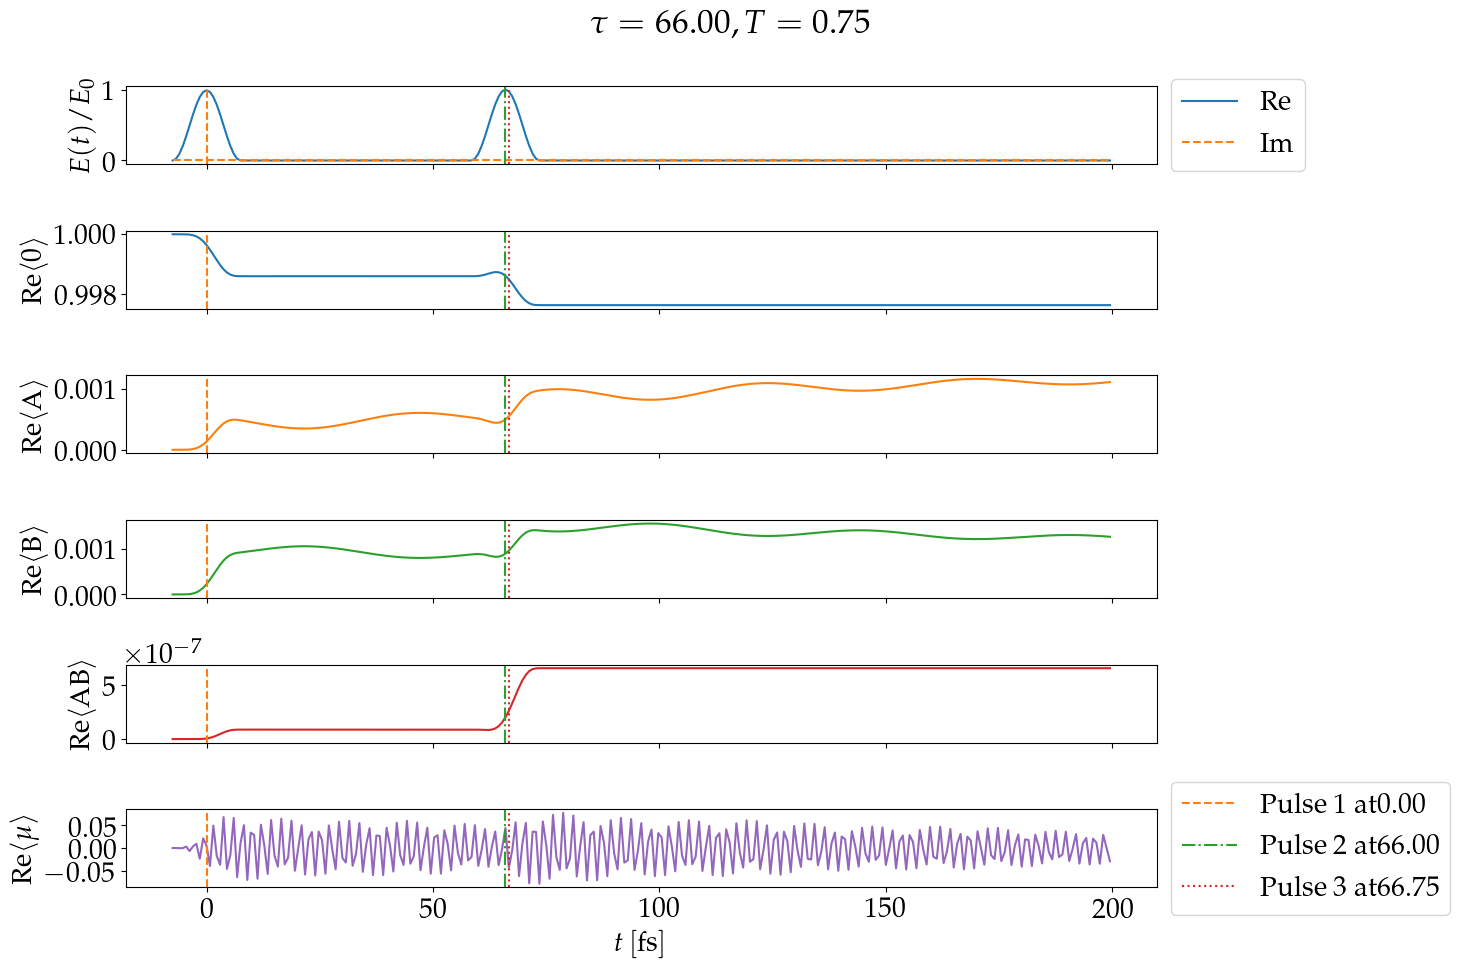

In [90]:
### Test Computation
t_max = 1*t_max_r
t_max_test     = 200 # -> determines Δω
fine_spacing_test = 5*fine_spacing # -> determines ω_max
print("fine_spacing", fine_spacing_test, "[fs]")
times_test = np.arange(-Delta_ts[0], t_max_test, fine_spacing_test)
print("times: ", times_test[0], times_test[1],"...",  times_test[-1], "len", len(times_test))

#  TODO ALWAYS CHECK Before running a serious simulation
result = check_the_solver(psi_ini, np.arange(-Delta_ts[0], 20*t_max, 10*fine_spacing), e_ops_list)
print("the evolution is actually unphisical after:", time_cut, "fs")

T_wait_test = 1* (times_test[1]- times_test[0])
data_test_0 = compute_two_dimensional_polarization(T_wait_test, phases[0], phases[0], times=times_test,  plot_example=True)

Plot not saved. Ensure 'safe' is True and 'output_dir' is specified.


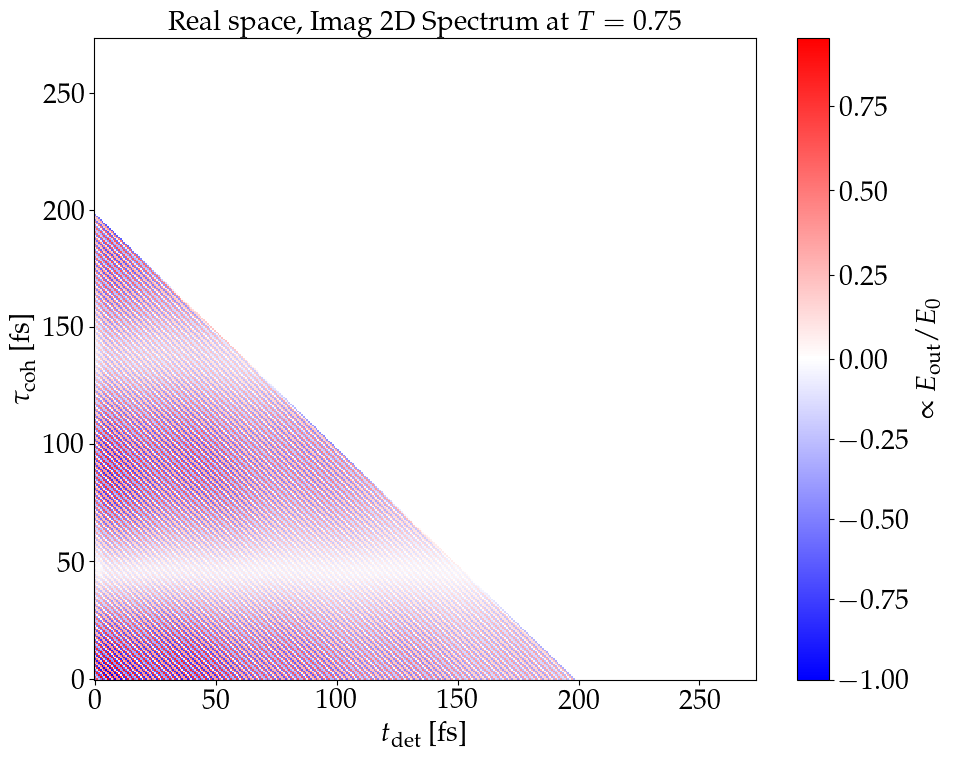

Plot not saved. Ensure 'safe' is True and 'output_dir' is specified.


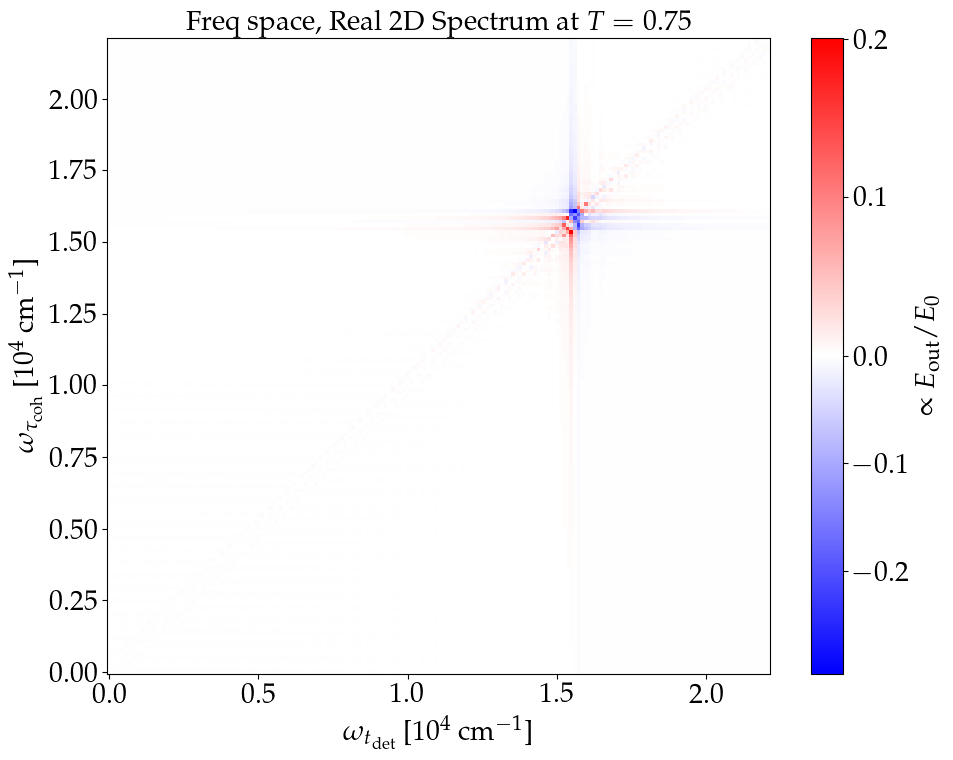

In [91]:
plot_args_freq = dict(                   # (**changeable**) 
    space="freq",                   
    type="real",                    # plot the real part (also "imag", "phase", "abs")
    safe=False,                     # (dont) save the spectrum
    positive=True,                  # only plot the positive spectrum
    use_custom_colormap=True,       # all zeros are white
    section=(                       # focus on the non zero part
        0, 3, # xmin, xmax,
        0, 3, # ymin, ymax
        ),

    # add more options as needed
)

ts, taus, data = data_test_0[0], data_test_0[1], data_test_0[2]
#ts, taus, data, omega_samples = data_test_1[0], data_test_1[1], data_test_1[2], data_test_1[3]

extend_for = (0, 100)
ts, taus, data = extend_time_tau_axes(ts, taus, data, pad_rows=extend_for, pad_cols=extend_for)
plot_positive_color_map(
    (ts, taus, data),
    type="imag", # because E ~ i*P
    T_wait=T_wait_test, 
    safe=False,
    use_custom_colormap=True,
)

nu_ts, nu_taus, s2d = compute_2d_fft_wavenumber(ts, taus, data)
plot_positive_color_map(
    (nu_ts, nu_taus, s2d),
    T_wait=T_wait_test, 
    **plot_args_freq
)

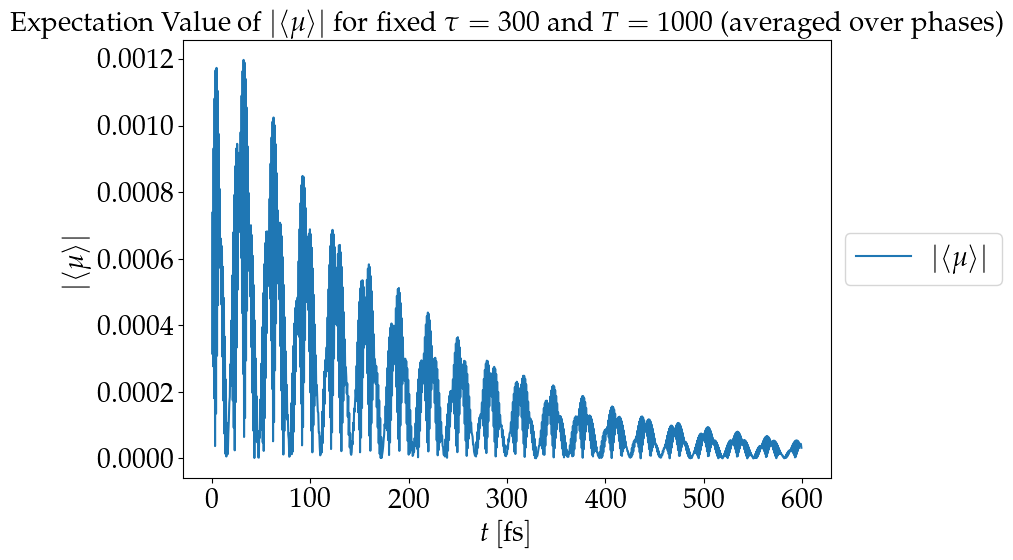

In [64]:
def compute_fixed_tau_T(tau_coh, T_wait, phi_0, phi_1, times):
    """
    Compute the data for a fixed tau_coh and T_wait.

    Parameters:
        tau_coh (float): Coherence time.
        T_wait (float): Waiting time.
        phi_0 (float): Phase of the first pulse.
        phi_1 (float): Phase of the second pulse.

    Returns:
        tuple: Time values and corresponding data.
    """

    idx_start_0 = 0     
    t_start_0 = times[idx_start_0] # ALWAYS the starting point of the first pulse
    idx_end_0 = np.abs(times - (Delta_ts[0])).argmin()
    idx_start_1 = np.abs(times - (tau_coh - Delta_ts[1])).argmin()
    t_start_1   = times[idx_start_1]  # Start time of the second pulse

    times_0 = times[: idx_start_1 + 1] # definetly not empty except for when T_wait >= t_max
    if times_0.size == 0:
        times_0 = times[:idx_end_0+1]
    # calculate the evolution of the first pulse in the desired range for tau_coh

    pulse_0=(t_start_0, phi_0)
    data_0 = compute_pulse_evolution(psi_ini, times_0, curr=pulse_0)

    rho_1 = data_0.states[idx_start_1]

    idx_end_1 = np.abs(times - (tau_coh + Delta_ts[1])).argmin() # index at which the second pulse ends
    # Take the state (after / also during) the first pulse and evolve it with the second (and potentially overlaped first) pulse

    # select range  ->  to reduce computation time
    idx_start_2 = np.abs(times - (tau_coh + T_wait - Delta_ts[2])).argmin()
    t_start_2 = times[idx_start_2] # the time at which the third pulse starts
    idx_end_2 = np.abs(times - (tau_coh + T_wait + Delta_ts[2])).argmin() # end of the third pulse
    # idx_start_2_0 = np.abs(times - (T_wait - Delta_ts[2])).argmin() # the first time at which the third pulse starts

    times_1 = times[idx_start_1:idx_start_2+1] # like this: also take the overlap into account; 
    
    if times_1.size == 0:
        times_1 = times[idx_start_1:idx_end_1+1]

    # Handle overlapping pulses: If the second pulse starts before the first pulse ends, combine their contributions
    pulse_1=(t_start_1, phi_1)
    data_1 = compute_pulse_evolution(rho_1, times_1, curr=pulse_1, prev=pulse_0)

    idx_start_2_in_times_1 = np.abs(times_1 - (t_start_2)).argmin()
    
    rho_2 = data_1.states[idx_start_2_in_times_1] # == state where the third pulse starts

    times_2 = times[idx_start_2:] # the rest of the evolution (third pulse, potentially overlapped with previouses) # can be empty, if tau_coh + T_wait >= t_max
    # print(len(times), len(times_0), len(times_1), len(times_2))
    if times_2.size == 0:
        times_2 = [times[idx_start_2]]
    # If the second pulse starts before the first pulse ends, combine their contributions
    phi_2 = 0 # FIXED PHASE!
    pulse_f=(t_start_2, phi_2)

    data_f = compute_pulse_evolution(rho_2, times_2, curr=pulse_f, prev=pulse_1, preprev=pulse_0)

    t_det_start_idx_in_times_2 = np.abs(times_2  - (times_2[0] + Delta_ts[2])).argmin() # detection time index in times_2
    t_last_puslse_peak = times_2[t_det_start_idx_in_times_2]
    # only if we are still in the physical regime
    states = data_f.states[t_det_start_idx_in_times_2:]
    t_det_vals = data_f.times[t_det_start_idx_in_times_2:]
    data = np.zeros((len(t_det_vals)), dtype=np.complex64) # might get uncontrollable big!TODO

    #print(t_det_vals[0], t_det_vals[1], t_det_vals[-1], len(t_det_vals))
    
    if RWA_laser:
        states = [
            apply_RWA_phase_factors(state, time, omega=omega_laser)
            for state, time in zip(states, t_det_vals)
        ]

    for (t_idx, t_det) in enumerate(t_det_vals):
        if t_det < time_cut:
            data[:] = np.real(expect(Dip_op, states[:]))
    return np.array(t_det_vals) - t_det_vals[0], data
# Plot the data for a fixed tau_coh and T_wait
def plot_fixed_tau_T(tau_coh, T_wait, phi_0, phi_1, times):
    """Plot the data for a fixed tau_coh and T."""
    t_det_vals, data = compute_fixed_tau_T(tau_coh, T_wait, phi_0, phi_1, times=times)

    plt.figure(figsize=(10, 6))
    plt.plot(t_det_vals, np.real(data), label=r"$|\langle \mu \rangle|$")
    plt.xlabel(r"$t \, [\text{fs}]$")
    plt.ylabel(r"$|\langle \mu \rangle|$")
    plt.title(
        r"Expectation Value of $|\langle \mu \rangle|$ for fixed $\tau$ and $T$ (T=1000, $\tau=300$)"
    )
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()

def compute_average_fixed_tau_T(tau_coh, T_wait, times, phases):
    """
    Compute the average data for a fixed tau_coh and T_wait over all phase combinations.

    Parameters:
        tau_coh (float): Coherence time.
        T_wait (float): Waiting time.
        phases (list): List of phase values.

    Returns:
        tuple: Time values and averaged data.
    """
    results = []
    for phi_0 in phases:
        for phi_1 in phases:
            try:
                result = compute_fixed_tau_T(tau_coh, T_wait, phi_0, phi_1, times=times)
                results.append(result)
            except Exception as e:
                print(f"Error in computation for phi_0={phi_0}, phi_1={phi_1}: {e}")
                raise

    # Average the results
    t_det_vals = results[0][0]  # Time values are the same for all computations
    data_sum = np.zeros_like(results[0][1], dtype=complex)
    for _, data in results:
        data_sum += data
    data_avg = data_sum / len(results)

    return t_det_vals, data_avg

def plot_average_fixed_tau_T(tau_coh, T_wait, times, phases):
    """
    Plot the averaged data for a fixed tau_coh and T_wait over all phase combinations.

    Parameters:
        tau_coh (float): Coherence time.
        T_wait (float): Waiting time.
        phases (list): List of phase values.

    Returns:
        None
    """
    t_det_vals, data_avg = compute_average_fixed_tau_T(tau_coh, T_wait, times, phases)

    plt.figure(figsize=(10, 6))
    plt.plot(t_det_vals, np.abs(data_avg), label=r"$|\langle \mu \rangle|$", color="C0", linestyle="solid")
    plt.xlabel(r"$t \, [\text{fs}]$")
    plt.ylabel(r"$|\langle \mu \rangle|$")
    plt.title(
        rf"Expectation Value of $|\langle \mu \rangle|$ for fixed $\tau={tau_coh}$ and $T={T_wait}$ (averaged over phases)"
    )
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()

# Test the function and plot the data
t_max_test     = 1900
fine_spacing_test = 0.5
times_test     = np.arange(-Delta_ts[0], t_max_test, fine_spacing_test)   # High-resolution times array to do the evolutions
tau_coh_test   = 300
T_wait_test    = 1000

#plot_fixed_tau_T(tau_coh_test, T_wait_test, phases[0], phases[1], times=times_test)
plot_average_fixed_tau_T(tau_coh_test, T_wait_test, times_test, phases)

In [ ]:
def for_one_time_calc_phase_comb(T_wait, phases, times, omega_at=omega_A):
    """
    Compute and average the 2D polarization for all phase combinations for one T_wait.
    Args:
        T_wait (float): Waiting time.
        phases (list): List of phase values.
        times (np.ndarray): Time grid for computation.
    Returns:
        np.ndarray: Averaged 2D polarization data for this T_wait.
    """
    num_combinations = len(phases) ** 2
    results         = []
    for phi1 in phases:
        for phi2 in phases:
            _, _, data = compute_two_dimensional_polarization(T_wait, phi1, phi2, times=times, omega_at=omega_at, plot_example=False)
            results.append(data)
    averaged_data = np.mean(np.stack(results), axis=0)
    return averaged_data

def parallel_process_all_combinations(phases, times_T, times, omega_at=omega_A):
    """
    Compute the averaged 2D polarization for all T_wait in times_T using all phase combinations.
    Args:
        phases (list): List of phase values.
        times_T (np.ndarray): Array of T_wait values.
        times (np.ndarray): Time grid for computation.
    Returns:
        list: List of averaged 2D polarization arrays for each T_wait.
    """
    results = [None] * len(times_T)

    # =============================
    # Parallelize over T_waits using ThreadPoolExecutor
    # =============================
    with ThreadPoolExecutor() as executor:
        future_to_idx = {
            executor.submit(for_one_time_calc_phase_comb, T_wait, phases, times, omega_at): idx
            for idx, T_wait in enumerate(times_T)
        }
        for future in as_completed(future_to_idx):
            idx             = future_to_idx[future]
            try:
                averaged_data = future.result()
            except Exception as exc:
                print(f"T_wait index {idx} generated an exception: {exc}")
                averaged_data = None
            results[idx] = averaged_data

    return results
def extend_and_plot_results(averaged_results, times_T, times, extend_for=None, **plot_args_freq):
    global_ts, global_taus = get_tau_cohs_and_t_dets_for_T_wait(times, times_T[0])
    global_data_time = np.zeros((len(global_taus), len(global_ts)), dtype=np.complex64)

    if extend_for is not None:
        global_ts, global_taus, global_data_time = extend_time_tau_axes(global_ts, global_taus, global_data_time, pad_rows=extend_for, pad_cols=extend_for)

    global_nu_ts, global_nu_taus, _ = compute_2d_fft_wavenumber(global_ts, global_taus, np.zeros((len(global_ts), len(global_taus))))
    global_data_freq = np.zeros((len(global_taus), len(global_ts)), dtype=np.complex64)

    # =============================
    # Combine all data arrays into global arrays for time and frequency domains
    # =============================

    # Initialize global arrays with zeros
    # global_ts and global_taus are the largest axes (from the first T_wait)
    # global_data_time and global_data_freq are already initialized above

    def find_closest_index(local_vals, global_vals):
        """Find indices in global_vals closest to each value in local_vals."""
        return [np.argmin(np.abs(global_vals - v)) for v in local_vals]

    for (i, data) in enumerate(averaged_results):
        T_wait = times_T[i]
        ts, taus = get_tau_cohs_and_t_dets_for_T_wait(times, T_wait)
        if extend_for is not None:
            ts, taus, data = extend_time_tau_axes(ts, taus, data, pad_rows=extend_for, pad_cols=extend_for)

        # Map local data into the global arrays
        tau_indices = find_closest_index(taus, global_taus)
        t_indices   = find_closest_index(ts, global_ts)
        for local_tau_idx, global_tau_idx in enumerate(tau_indices):
            for local_t_idx, global_t_idx in enumerate(t_indices):
                # Check bounds before assignment to avoid IndexError
                if global_tau_idx < global_data_time.shape[0] and global_t_idx < global_data_time.shape[1]:
                    global_data_time[global_tau_idx, global_t_idx] += data[local_tau_idx, local_t_idx]
                    ####            global_data_freq[global_tau_idx, global_t_idx] += data_freq[local_tau_idx, local_t_idx]
                else:
                    # Print debug info if index is out of bounds
                    print(f"IndexError: global_tau_idx={global_tau_idx}, global_t_idx={global_t_idx}, shape={global_data_time.shape}")
        """
        nu_ts, nu_taus, data_freq = compute_2d_fft_wavenumber(ts, taus, data)
        plot_positive_color_map(
            (ts, taus, data), 
            times_T[i], 
            type="imag",
            use_custom_colormap=True,
            )

        plot_positive_color_map(
            (nu_ts, nu_taus, data_freq),
            times_T[i],
            **plot_args_freq
        )"""


    # Normalize by number of T_waits
    global_data_time /= len(averaged_results)
    global_data_freq /= len(averaged_results)

    # Plot the global results
    plot_positive_color_map(
        (global_ts, global_taus, global_data_time),
        type="imag",
        use_custom_colormap=True,
    )
    plot_positive_color_map(
        (global_nu_ts, global_nu_taus, global_data_freq),
        **plot_args_freq
    )

In [ ]:
# Test the function and plot the data
#t_max_test     = 100 # -> determines Δω
#fine_spacing_test = 1 # -> determines ω_max
times_test     = np.arange(-Delta_ts[0], t_max_test, fine_spacing_test)
print("times: ", times_test[0], times_test[1],"...",  times_test[-1], "len", len(times_test))
times_T_test = (np.array([0])# , 16, 30, 46, 62, 108, 140, 310])
)  # np.arange(T_wait_0, last_entry, sparse_spacing)

RESULT = parallel_process_all_combinations(phases ,times_T=times_T_test, times=times_test)

times:  -7.5 -6.75 ... 199.5 len 277


Plot not saved. Ensure 'safe' is True and 'output_dir' is specified.


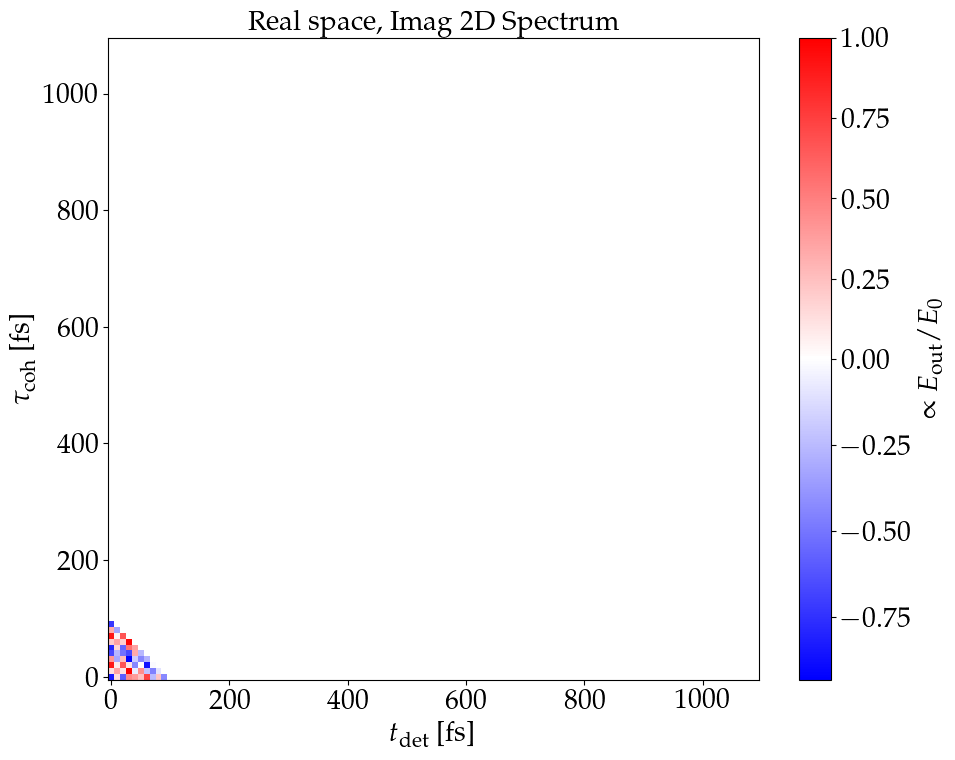

Plot not saved. Ensure 'safe' is True and 'output_dir' is specified.


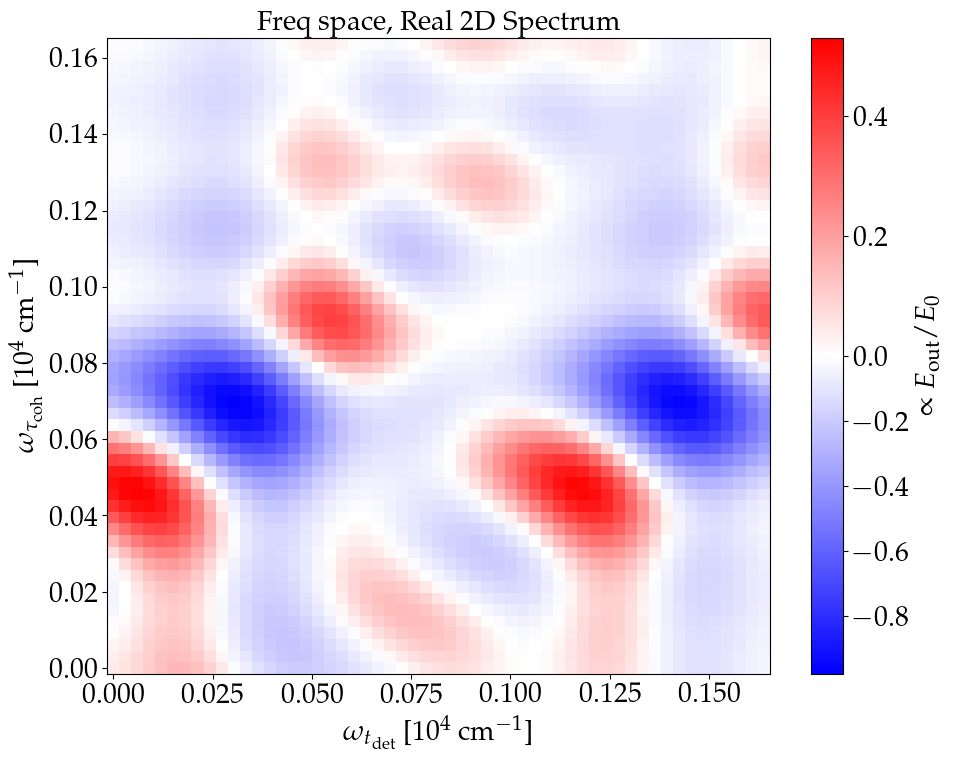

In [ ]:
# Example usage
extend_and_plot_results(RESULT, times_T=times_T_test, times=times_test, extend_for=extend_for, **plot_args_freq)